## Model Interpretability with  Descriptive mAchine Learning EXplanations 

DALEX allows for global to local interpretability method.

In [1]:
# load required packages
library(rsample)
library(dplyr)
library(h2o)
library(DALEX)
library(ggplot2)

Loading required package: tidyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc

Welcome to DALEX (version: 0.2.6).

Attaching package: ‘DALEX’

The fo

In [2]:
# initialize h2o session
h2o.no_progress()
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/qc/2jrzvt8d0p31zx89hvng6pd80000gn/T//RtmpwXihJK/h2o_krish_started_from_r.out
    /var/folders/qc/2jrzvt8d0p31zx89hvng6pd80000gn/T//RtmpwXihJK/h2o_krish_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 818 milliseconds 
    H2O cluster timezone:       Europe/Berlin 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    2 months and 6 days  
    H2O cluster name:           H2O_started_from_R_krish_mda571 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
  

In [3]:
# classification data
df <- rsample::attrition %>% 
  mutate_if(is.ordered, factor, ordered = FALSE) %>%
  mutate(Attrition = recode(Attrition, "Yes" = "1", "No" = "0") %>% factor(levels = c("1", "0")))

In [4]:
# convert to h2o object
df.h2o <- as.h2o(df)

In [5]:
# create train, validation, and test splits
set.seed(123)
splits <- h2o.splitFrame(df.h2o, ratios = c(.7, .15), destination_frames = c("train","valid","test"))
names(splits) <- c("train","valid","test")

In [6]:
# variable names for resonse & features
y <- "Attrition"
x <- setdiff(names(df), y) 

In [7]:
# elastic net model 
glm <- h2o.glm(
  x = x, 
  y = y, 
  training_frame = splits$train,
  validation_frame = splits$valid,
  family = "binomial",
  seed = 123
  )

In [8]:
# random forest model
rf <- h2o.randomForest(
  x = x, 
  y = y,
  training_frame = splits$train,
  validation_frame = splits$valid,
  ntrees = 1000,
  stopping_metric = "AUC",    
  stopping_rounds = 10,         
  stopping_tolerance = 0.005,
  seed = 123
  )

In [9]:
# gradient boosting machine model
gbm <-  h2o.gbm(
  x = x, 
  y = y,
  training_frame = splits$train,
  validation_frame = splits$valid,
  ntrees = 1000,
  stopping_metric = "AUC",    
  stopping_rounds = 10,         
  stopping_tolerance = 0.005,
  seed = 123
  )

In [10]:
# model performance
h2o.auc(glm, valid = TRUE)

[1] 0.7870935

In [11]:
# model performance
h2o.auc(rf, valid = TRUE)

[1] 0.7681021

In [12]:
# model performance
h2o.auc(gbm, valid = TRUE)

[1] 0.7468242

In [13]:
# convert feature data to non-h2o objects
x_valid <- as.data.frame(splits$valid)[, x]

In [14]:
# make response variable numeric binary vector
y_valid <- as.vector(as.numeric(as.character(splits$valid$Attrition)))
head(y_valid)

[1] 0 0 0 0 0 0

In [15]:
# create custom predict function
pred <- function(model, newdata)  {
  results <- as.data.frame(h2o.predict(model, as.h2o(newdata)))
  return(results[[3L]])
  }

In [16]:
pred(rf, x_valid) %>% head()

[1] 0.18181818 0.27272727 0.06060606 0.54545455 0.03030303 0.42424242

In [17]:
# elastic net explainer
explainer_glm <- explain(
  model = glm,
  data = x_valid,
  y = y_valid,
  predict_function = pred,
  label = "h2o glm"
  )

In [18]:
# random forest explainer
explainer_rf <- explain(
  model = rf,
  data = x_valid,
  y = y_valid,
  predict_function = pred,
  label = "h2o rf"
  )

In [19]:
# GBM explainer
explainer_gbm <- explain(
  model = gbm,
  data = x_valid,
  y = y_valid,
  predict_function = pred,
  label = "h2o gbm"
  )

In [20]:
# example of explainer object
class(explainer_glm)

# summary "explainer"
summary(explainer_glm)

[1] "explainer"

                 Length Class            Mode     
model              1    H2OBinomialModel S4       
data              30    data.frame       list     
y                233    -none-           numeric  
predict_function   1    -none-           function 
link               1    -none-           function 
class              1    -none-           character
label              1    -none-           character

### Residual diagnostics

In [21]:
# compute predictions & residuals
resids_glm <- model_performance(explainer_glm)
resids_rf  <- model_performance(explainer_rf)
resids_gbm <- model_performance(explainer_gbm)

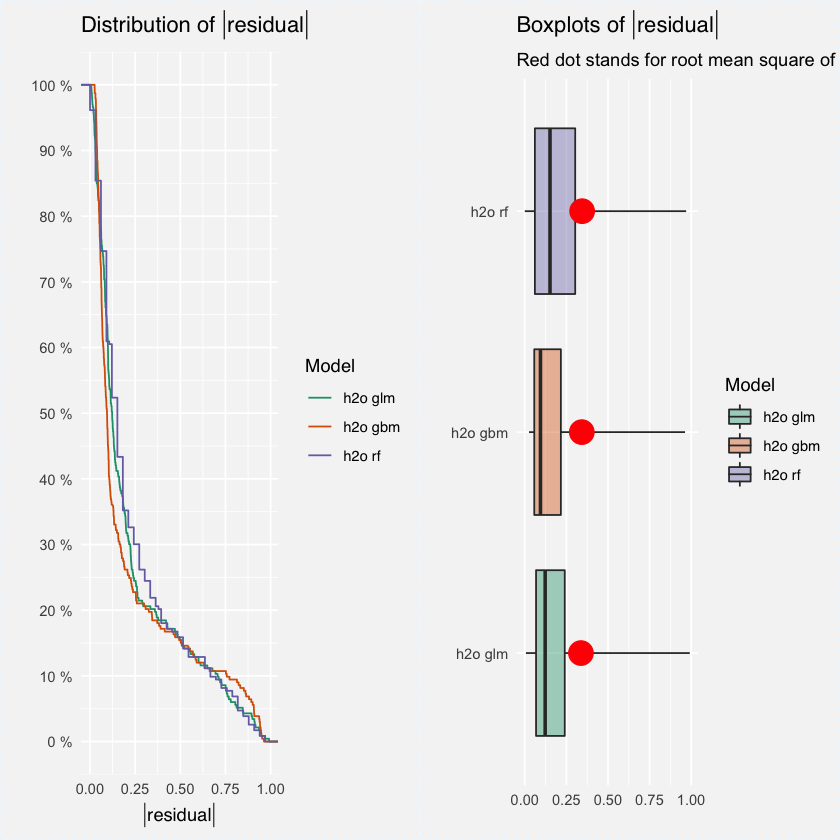

In [22]:
# create comparison plot of residuals for each model
p1 <- plot(resids_glm, resids_rf, resids_gbm)
p2 <- plot(resids_glm, resids_rf, resids_gbm, geom = "boxplot")

gridExtra::grid.arrange(p1, p2, nrow = 1)

### Variable importance

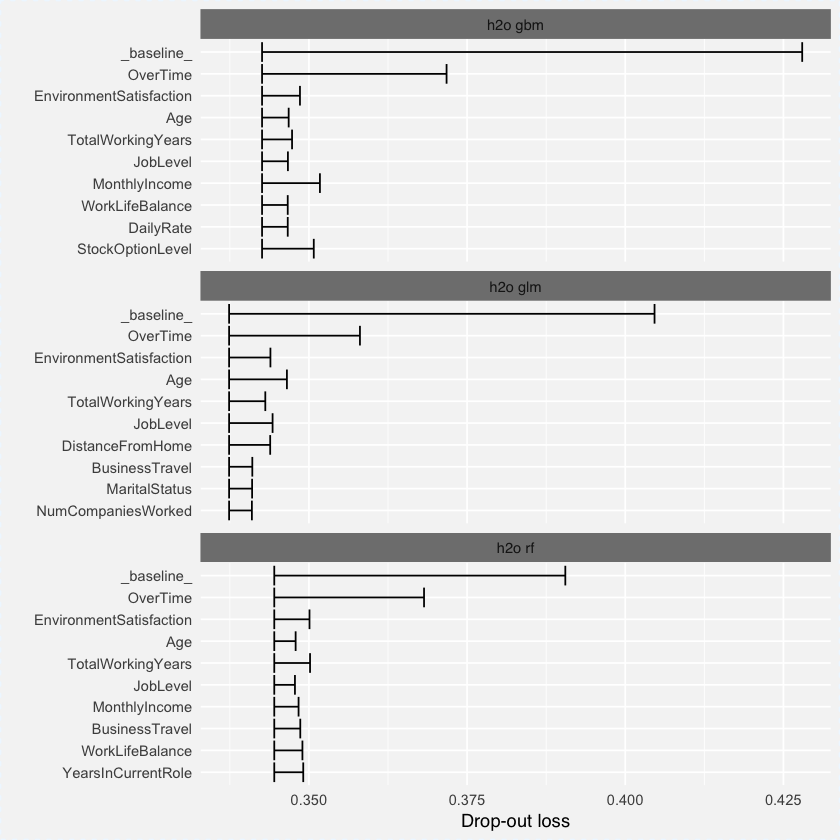

In [23]:
# compute permutation-based variable importance
vip_glm <- variable_importance(explainer_glm, n_sample = -1, loss_function = loss_root_mean_square) 
vip_rf  <- variable_importance(explainer_rf, n_sample = -1, loss_function = loss_root_mean_square)
vip_gbm <- variable_importance(explainer_gbm, n_sample = -1, loss_function = loss_root_mean_square)

plot(vip_glm, vip_rf, vip_gbm, max_vars = 10)

In [24]:
# time to compute importance scores
system.time({
  vip_glm <- variable_importance(explainer_glm) 
  vip_rf  <- variable_importance(explainer_rf)
  vip_gbm <- variable_importance(explainer_gbm)
})

   user  system elapsed 
 20.797   0.796  55.500 

### Predictor-response relationship

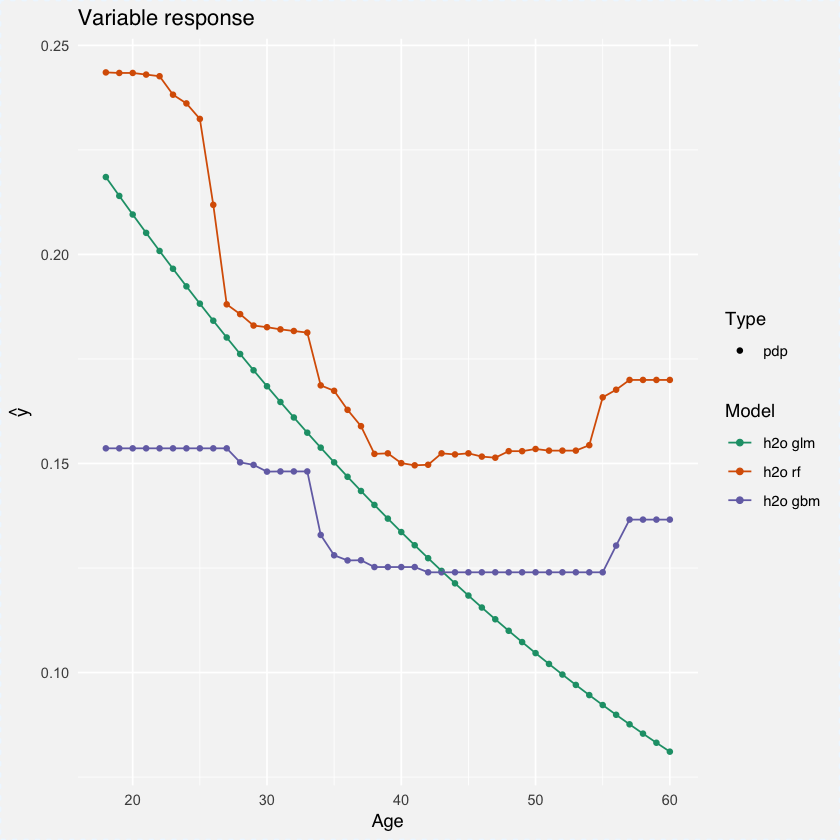

In [25]:
# compute PDP for a given variable --> uses the pdp package
pdp_glm  <- variable_response(explainer_glm, variable =  "Age", type = "pdp")
pdp_rf   <- variable_response(explainer_rf,  variable =  "Age", type = "pdp")
pdp_gbm  <- variable_response(explainer_gbm, variable =  "Age", type = "pdp")

plot(pdp_glm, pdp_rf, pdp_gbm)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


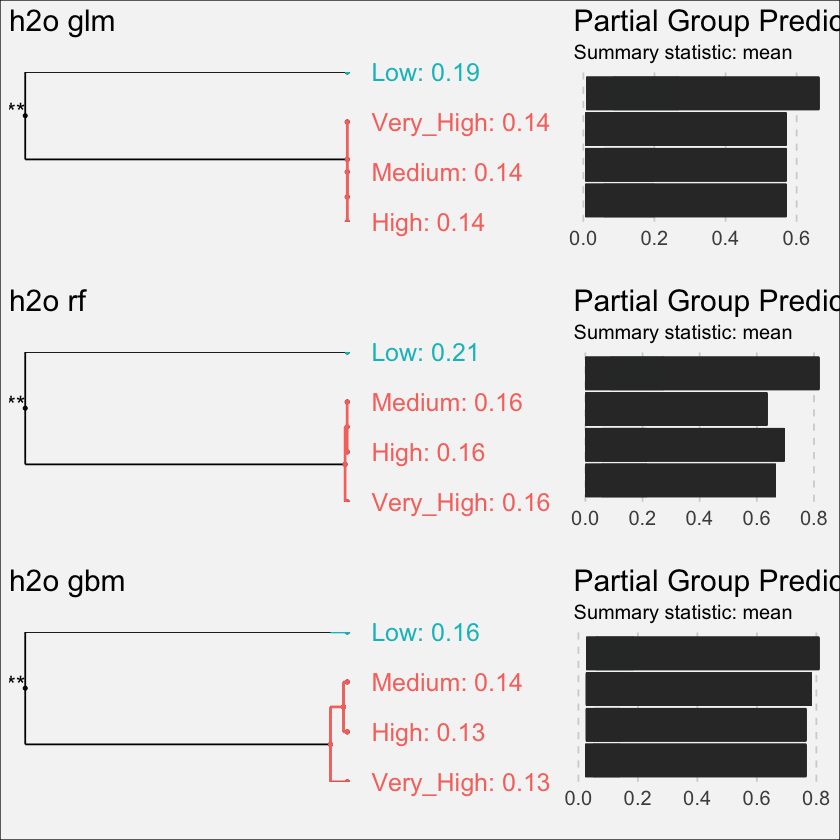

In [26]:
cat_glm  <- variable_response(explainer_glm, variable = "EnvironmentSatisfaction", type = "factor")
cat_rf  <- variable_response(explainer_rf, variable = "EnvironmentSatisfaction", type = "factor")
cat_gbm  <- variable_response(explainer_gbm, variable = "EnvironmentSatisfaction", type = "factor")
plot(cat_glm, cat_rf, cat_gbm)

In [27]:
# create a single observation
new_cust <- splits$valid[1, ] %>% as.data.frame()

In [ ]:
# compute breakdown distances
new_cust_glm <- prediction_breakdown(explainer_glm, observation = new_cust)
new_cust_rf  <- prediction_breakdown(explainer_rf, observation = new_cust)
new_cust_gbm <- prediction_breakdown(explainer_gbm, observation = new_cust)

In [ ]:
# class of prediction_breakdown output
class(new_cust_gbm)

# "prediction_breakdown_explainer" "data.frame"

# check out the top 10 influential variables for this observation
new_cust_gbm[1:10, 1:5]

In [ ]:
plot(new_cust_gbm)

In [ ]:
# filter for top 10 influential variables for each model and plot
list(new_cust_glm, new_cust_rf, new_cust_gbm) %>%
  purrr::map(~ top_n(., 11, wt = abs(contribution))) %>%
  do.call(rbind, .) %>%
  mutate(variable = paste0(variable, " (", label, ")")) %>%
  ggplot(aes(contribution, reorder(variable, contribution))) +
  geom_point() +
  geom_vline(xintercept = 0, size = 3, color = "white") +
  facet_wrap(~ label, scales = "free_y", ncol = 1) +
  ylab(NULL)

In [ ]:
# ames data
ames.h2o <- as.h2o(AmesHousing::make_ames())

In [ ]:
# create local observation
local_ob <- as.data.frame(ames.h2o[1, ])

In [ ]:
# variable names for resonse & features
y <- "Sale_Price"
x <- setdiff(names(ames.h2o), y)

In [ ]:
# random forest model
rf <- h2o.randomForest(
  x = x, 
  y = y,
  training_frame = ames.h2o,
  ntrees = 1000
  )

In [ ]:
# get features for explainer
x_valid <- as.data.frame(ames.h2o)[, x]
y_valid <- as.vector(ames.h2o[y])

In [ ]:
# create custom predict function
pred <- function(model, newdata)  {
  results <- as.vector(predict(model, as.h2o(newdata)))
  return(results)
}


In [ ]:
# create explainer
ames_rf <- explain(
  model = rf,
  data = x_valid,
  y = y_valid,
  predict_function = pred,
  label = "ames"
  )

In [ ]:
# time to compute prediction break down
system.time({
  ames_example  <- prediction_breakdown(ames_rf, observation = local_ob)
})